# Weighting of dynamic structure factor with form factors

In this tutorial we focuss on post-processing the structure factors with neutron scattering lengths or X-ray form factors, as different features in the full dispersion are visible depending on which probe is used in a scattering experiment. We use solid (B2-ordered) NiAl to illustrate this.

Because we return to the same system used in the multi-component tutorial, we assume that the molecular dynamics trajectories have already been created beforehand with [GPUMD](https://gpumd.org/) with the [UNEP model](https://zenodo.org/records/10081677). See `examples/NiAl-ordered-and-disordered/NiAl-runmd.py` for the runscript.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ase.build import bulk
from seekpath import get_path

from dynasor import compute_dynamic_structure_factors, Trajectory
from dynasor.qpoints import get_supercell_qpoints_along_path
from dynasor.units import radians_per_fs_to_meV as conversion_factor

## Compute correlation functions

Here we set up the Trajectory, $\boldsymbol{q}$-points, and compute the dynamic structure factor. See the [dynamic properties of NiAl tutorial](https://dynasor.materialsmodeling.org/tutorials/NiAl-ordered-and-disordered.html) for a step-by-step explanation of this. 

In [3]:
# Set up trajectory
traj = Trajectory(f'../NiAl-ordered-and-disordered/ordered/dump.xyz', 
                  trajectory_format='extxyz',
                  atomic_indices='read_from_trajectory',
                  length_unit='Angstrom', 
                  time_unit='fs',
                  frame_step=1,
                  frame_stop=None)

# Set up path through Brillouin zone
repeats = 24 # We simulated a 24x24x24 supercell
prim = bulk('Al', a=traj.cell[0][0]/repeats)
path_info = get_path((prim.cell, prim.get_scaled_positions(), prim.numbers))
point_coordinates = path_info['point_coords']
path = path_info['path']

q_segments = get_supercell_qpoints_along_path(
    path, point_coordinates, prim.cell, traj.cell)
q_points = np.vstack(q_segments)

# Compute correlation functions
delta_t = 5.0 # MD time step used (fs)
dump_every = 5 # How often the frames were dumped during MD

sample = compute_dynamic_structure_factors(traj, q_points, 
                                           dt=delta_t*dump_every, 
                                           window_size=2000,
                                           window_step=100)

INFO: Trajectory file: ../NiAl-ordered-and-disordered/ordered/dump.xyz
INFO: Total number of particles: 27648
INFO: Number of atom types: 2
INFO: Number of atoms of type Al: 13824
INFO: Number of atoms of type Ni: 13824
INFO: Simulation cell (in Angstrom):
[[68.64  0.    0.  ]
 [ 0.   68.64  0.  ]
 [ 0.    0.   68.64]]
INFO: Spacing between samples (frame_step): 1
INFO: Time between consecutive frames in input trajectory (dt): 25.0 fs
INFO: Time between consecutive frames used (dt * frame_step): 25.0 fs
INFO: Time window size (dt * frame_step * window_size): 50000.0 fs
INFO: Angular frequency resolution: dw = 0.000063 rad/fs = 0.041 meV
INFO: Maximum angular frequency (dw * window_size): 0.125664 rad/fs = 82.713 meV
INFO: Nyquist angular frequency (2pi / frame_step / dt / 2): 0.125664 rad/fs = 82.713 meV
INFO: Number of q-points: 90


In [4]:
display(sample)

DynamicSample
Atom types: ['Al', 'Ni']
Pairs: [('Al', 'Al'), ('Al', 'Ni'), ('Ni', 'Ni')]
Particle counts: {'Al': 13824, 'Ni': 13824}
Simulations cell:
[[68.64  0.    0.  ]
 [ 0.   68.64  0.  ]
 [ 0.    0.   68.64]]
omega           with shape: (2001,)
q_points        with shape: (90, 3)
time            with shape: (2001,)
Fqt             with shape: (90, 2001)
Fqt_coh         with shape: (90, 2001)
Fqt_coh_Al_Al   with shape: (90, 2001)
Fqt_coh_Al_Ni   with shape: (90, 2001)
Fqt_coh_Ni_Ni   with shape: (90, 2001)
Sqw             with shape: (90, 2001)
Sqw_coh         with shape: (90, 2001)
Sqw_coh_Al_Al   with shape: (90, 2001)
Sqw_coh_Al_Ni   with shape: (90, 2001)
Sqw_coh_Ni_Ni   with shape: (90, 2001)

## Weighting with neutron scattering lengths

To post-process the raw structure factor with weights of any kind, we need to first create a `Weights` object, which we then use to compute the weighted sample using the `get_weighted_sample` functionality. 

In [5]:
from dynasor.post_processing import Weights, get_weighted_sample
from dynasor.post_processing import NeutronScatteringLengths

Let's begin by creating the `Weights` object. We first illustrate how this is done in **dynasor** without bothering about the actual values of the scattering lengths, so we set the weights for both Ni and Al to 1. Instead of these dummy values, the weights could for example correspond to the charges, masses or, as we shall see below, scattering lengths or form factors, depending on the desired weighted correlation function.

In [6]:
weights = Weights({'Ni': 1, 'Al': 1})
print(weights)

weights coherent:
  Ni: 1
  Al: 1


The weights we created like this are coherent weights. If we would have computed the incoherent structure factor in  `compute_dynamic_structure_dactors` above (which is done using `include_incoherent=True`), we could have set the (generally different) incoherent scattering lengths as well, via a second dictionary:

In [7]:
weights = Weights({'Ni': 1, 'Al': 1}, {'Ni': 1, 'Al': 1})
print(weights)

weights coherent:
  Ni: 1
  Al: 1
weights incoherent:
  Ni: 1
  Al: 1


Now we want to generate some real weights, that we want to use to perform the weighting of the raw structure factor. This can be done manually by creating the `Weights` object as above, using your favorite table of neutron scattering lengths, but for convenience we provide tabulated values directly via `NeutronScatteringLengths`, taken from [this NIST database](https://www.ncnr.nist.gov/resources/n-lengths/list.html), which in turn have been taken from Table 1 of Neutron News **3**, 26 (1992);
[doi: 10.1080/10448639208218770](https://doi.org/10.1080/10448639208218770).

In [8]:
neutron_weights = NeutronScatteringLengths(['Ni', 'Al'])
print(neutron_weights)

weights coherent:
  Al: 3.449
  Ni: 10.331863
weights incoherent:
  Al: 0.065536
  Ni: 0.0019421648999999998


In [9]:
sample_neutron = get_weighted_sample(sample, neutron_weights)

In [10]:
display(sample_neutron)

DynamicSample
Atom types: ['Al', 'Ni']
Pairs: [('Al', 'Al'), ('Al', 'Ni'), ('Ni', 'Ni')]
Particle counts: {'Al': 13824, 'Ni': 13824}
Simulations cell:
[[68.64  0.    0.  ]
 [ 0.   68.64  0.  ]
 [ 0.    0.   68.64]]
omega           with shape: (2001,)
q_points        with shape: (90, 3)
time            with shape: (2001,)
Fqt             with shape: (90, 2001)
Fqt_coh         with shape: (90, 2001)
Fqt_coh_Al_Al   with shape: (90, 2001)
Fqt_coh_Al_Ni   with shape: (90, 2001)
Fqt_coh_Ni_Ni   with shape: (90, 2001)
Sqw             with shape: (90, 2001)
Sqw_coh         with shape: (90, 2001)
Sqw_coh_Al_Al   with shape: (90, 2001)
Sqw_coh_Al_Ni   with shape: (90, 2001)
Sqw_coh_Ni_Ni   with shape: (90, 2001)

## Visualize the neutron weighted structure factor

We visualize the effect of the weighting by studying slices of $S(\boldsymbol{q}, \omega)$ in $\boldsymbol{q}$-space.

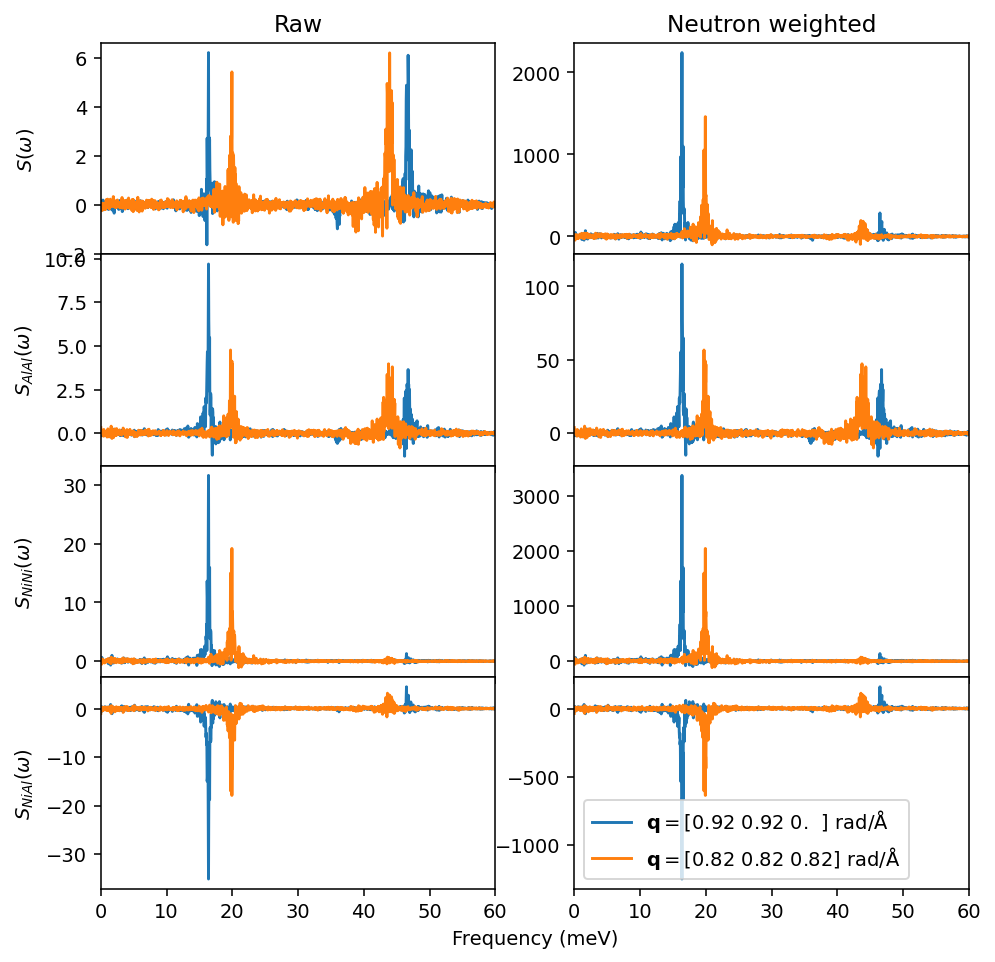

In [11]:
fig, axes = plt.subplots(figsize=(8, 8), ncols=2, nrows=4, dpi=140, sharex=True)

qids = [40, 60]

for qid in qids:
    axes[0][0].plot(conversion_factor * sample.omega, sample.Sqw_coh[qid])
    axes[1][0].plot(conversion_factor * sample.omega, sample.Sqw_coh_Al_Al[qid])
    axes[2][0].plot(conversion_factor * sample.omega, sample.Sqw_coh_Ni_Ni[qid])
    axes[3][0].plot(conversion_factor * sample.omega, sample.Sqw_coh_Al_Ni[qid])
    

    axes[0][1].plot(conversion_factor * sample_neutron.omega, sample_neutron.Sqw_coh[qid])
    axes[1][1].plot(conversion_factor * sample_neutron.omega, sample_neutron.Sqw_coh_Al_Al[qid])
    axes[2][1].plot(conversion_factor * sample_neutron.omega, sample_neutron.Sqw_coh_Ni_Ni[qid])
    axes[3][1].plot(conversion_factor * sample_neutron.omega, sample_neutron.Sqw_coh_Al_Ni[qid],
                    label='$\mathbf{q} =$' + np.array_str(sample.q_points[qid], precision=2, suppress_small=True)+' rad/Å')

ax = axes[0][0]
ax.set_ylabel('$S(\omega)$')
ax.set_title('Raw')
ax.set_xlim((0,60))

axes[1][0].set_ylabel('$S_{AlAl}(\omega)$')
axes[2][0].set_ylabel('$S_{NiNi}(\omega)$')
axes[3][0].set_ylabel('$S_{NiAl}(\omega)$')
axes[3][0].set_xlabel('Frequency (meV)', x=1.1)
axes[0][1].set_title('Neutron weighted')
axes[3][1].legend();

fig.subplots_adjust(hspace=0)
fig.align_ylabels()

From the figures above, we can see that in each $\boldsymbol{q}$-slice of the raw total structure factor (top left), the low-frequency and the high-frequency peaks appear to be of similar height, while their intensities differ when the structure factor is weighted with neutron scattering lengths (top right). This is explained by the partial structure factors contributing in different amounts to the total, since the neutron scattering lengths for Ni and Al are different, so when adding the weighted partials up to obtain the total weighted structure factor the aspect ratio between the low-frequency and the high-frequency peaks changes compared to the raw total structure factor.

## Weighting with X-ray form factors

Now, we will do the same thing, but with X-ray form factors instead. Just as for the neutron weights, we provide tabulated values for X-ray form factors via `XRayFormFactors`. Here, there are two possible sources that can be specified, depending on the desired parametrization: `source='waasmaier-1995'` (taken from table 1 from D. Waasmaier, A. Kirfel, Acta Crystallographica Section A **51**, 416 (1995); [doi: 10.1107/S0108767394013292](https://doi.org/10.1107/S0108767394013292)) or `source='international-iv-1974'` (taken from Table 2.2B from *International Tables for X-ray Crystallography , Vol. IV*, The Kynoch Press: Birmingham, England, 1974). If no source is specified, the default is `waasmaier-1995`. This is a convenience function, but if you would like to use a different source for the X-ray form factors, recall that it is possible to manually create a `Weights` object.

In [12]:
from dynasor.post_processing import XRayFormFactors

In [13]:
xray_weights = XRayFormFactors(['Ni', 'Al'])
print(xray_weights)

weights coherent:
  Al: {'method': 'RHF', 'a1': 4.730796, 'b1': 3.620931, 'a2': 2.313951, 'b2': 43.051166, 'a3': 1.54198, 'b3': 0.09596, 'a4': 1.117564, 'b4': 100.932109, 'a5': 3.154754, 'b5': 1.555918, 'c': 0.139509}
  Ni: {'method': 'RHF', 'a1': 13.521865, 'b1': 4.077277, 'a2': 6.947285, 'b2': 0.286763, 'a3': 3.866028, 'b3': 14.622634, 'a4': 2.1359, 'b4': 71.966078, 'a5': 4.284731, 'b5': 0.004437, 'c': -2.762697}


While the neutron scattering lengths are independent of $\boldsymbol{q}$, the X-ray form factors have a $|\boldsymbol{q}|$-dependence. For this reason, `XRayFormFactors` contains the parametrization, which allows for calculating the actual weight at the relevant $\boldsymbol{q}$. Before perfoming the weighting,, let's visualize the q-dependance of the Ni and Al X-ray form factors.

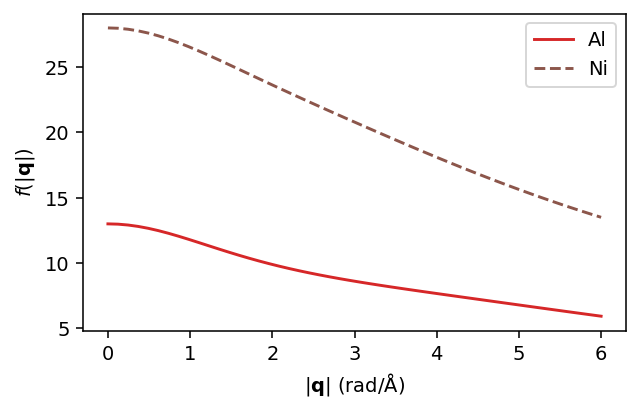

In [15]:
q_plot = np.linspace(0,6)
xray_ff_Ni_plot = [xray_weights.get_weight_coh('Ni', q) for q in q_plot]
xray_ff_Al_plot = [xray_weights.get_weight_coh('Al', q) for q in q_plot]

fig, ax = plt.subplots(figsize=(5, 3), ncols=1, nrows=1, dpi=140)
ax.plot(q_plot, xray_ff_Al_plot, label='Al', color='C3')
ax.plot(q_plot, xray_ff_Ni_plot, '--', label='Ni', color='C5')

ax.set_xlabel('$|\mathbf{q}|$ (rad/Å)')
ax.set_ylabel('$f(|\mathbf{q}|)$')
ax.legend();

X-ray form factors roughly scale as the atomic number Z for different species, resulting in heavier elements being much more visible than lighter. This can be seen from the fact that Al (Z=13) and Ni (Z=28) differ by about a factor of two above.

When actually using the `XRayFormFactors` to compute the weights, **dynasor** internally checks the $\boldsymbol{q}$-values for which the raw sample has been computed and calculates the X-ray form factor values at these $\boldsymbol{q}$-values, which means that computing the weighted sample is easily done in the same way as before:

In [16]:
sample_xray = get_weighted_sample(sample, xray_weights)

We can now compare the sample weighted with neutron scattering lengths to the sample weighted with the X-ray form factors. Again, we'll look at some slices of $S(\boldsymbol{q}, \omega)$ in $\boldsymbol{q}$-space.

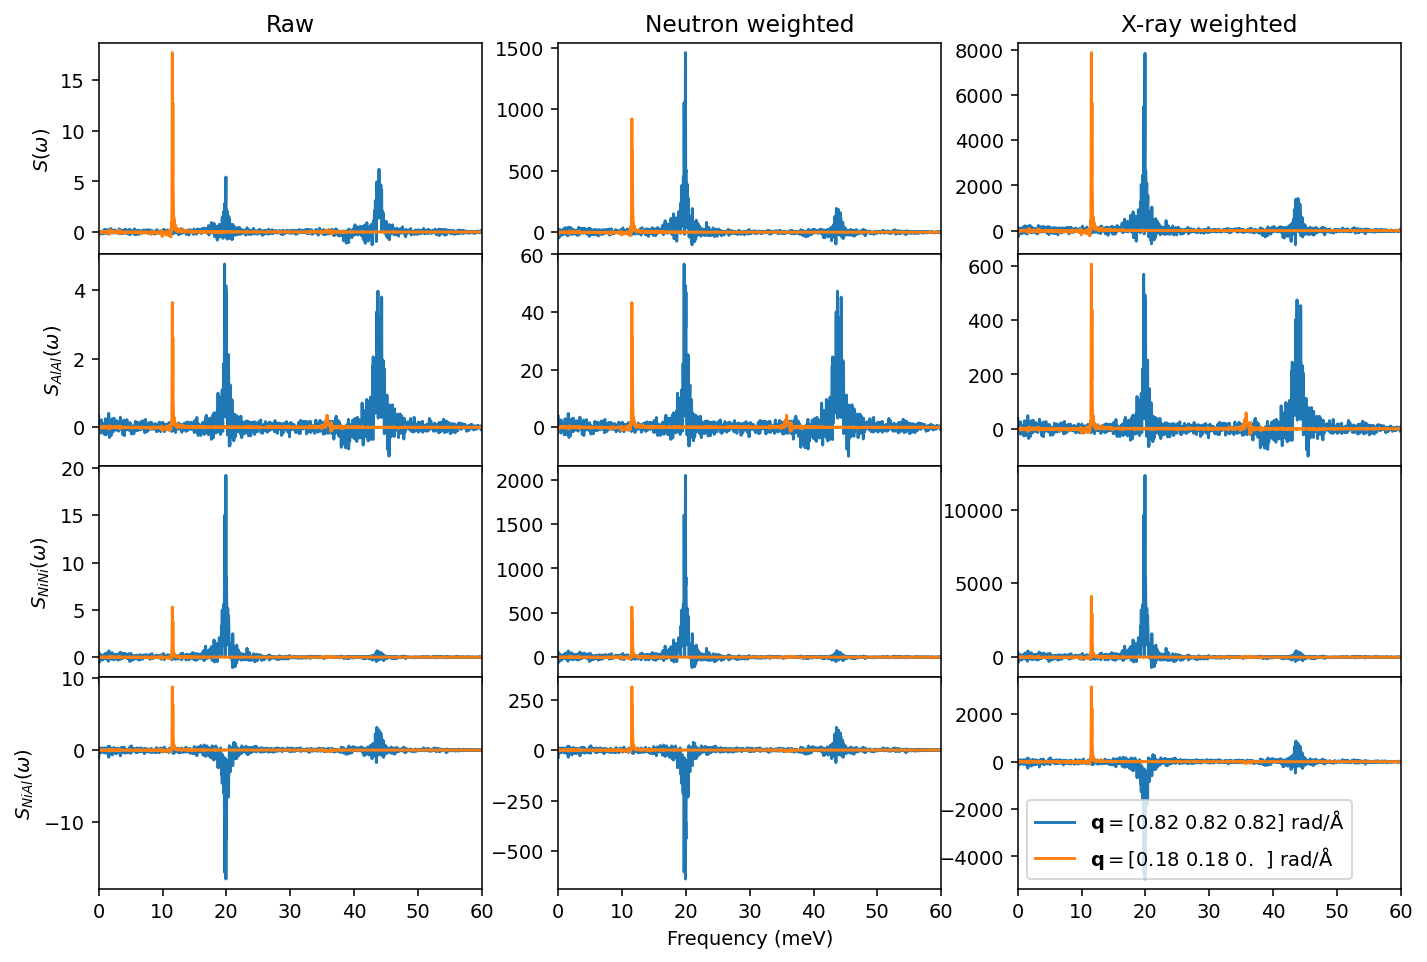

In [17]:
fig, axes = plt.subplots(figsize=(12, 8), ncols=3, nrows=4, dpi=140, sharex=True)

qids = [60, 48]

for qid in qids:
    axes[0][0].plot(conversion_factor * sample.omega, sample.Sqw_coh[qid])
    axes[1][0].plot(conversion_factor * sample.omega, sample.Sqw_coh_Al_Al[qid])
    axes[2][0].plot(conversion_factor * sample.omega, sample.Sqw_coh_Ni_Ni[qid])
    axes[3][0].plot(conversion_factor * sample.omega, sample.Sqw_coh_Al_Ni[qid])
    
    axes[0][1].plot(conversion_factor * sample_neutron.omega, sample_neutron.Sqw_coh[qid])
    axes[1][1].plot(conversion_factor * sample_neutron.omega, sample_neutron.Sqw_coh_Al_Al[qid])
    axes[2][1].plot(conversion_factor * sample_neutron.omega, sample_neutron.Sqw_coh_Ni_Ni[qid])
    axes[3][1].plot(conversion_factor * sample_neutron.omega, sample_neutron.Sqw_coh_Al_Ni[qid])

    axes[0][2].plot(conversion_factor * sample_xray.omega, sample_xray.Sqw_coh[qid])
    axes[1][2].plot(conversion_factor * sample_xray.omega, sample_xray.Sqw_coh_Al_Al[qid])
    axes[2][2].plot(conversion_factor * sample_xray.omega, sample_xray.Sqw_coh_Ni_Ni[qid])
    axes[3][2].plot(conversion_factor * sample_xray.omega, sample_xray.Sqw_coh_Al_Ni[qid],
                    label='$\mathbf{q} =$' + np.array_str(sample.q_points[qid], precision=2, suppress_small=True)+' rad/Å')

ax = axes[0][0]
ax.set_ylabel('$S(\omega)$')
ax.set_title('Raw')
ax.set_xlim((0,60))

axes[1][0].set_ylabel('$S_{AlAl}(\omega)$')
axes[2][0].set_ylabel('$S_{NiNi}(\omega)$')
axes[3][0].set_ylabel('$S_{NiAl}(\omega)$')
axes[3][1].set_xlabel('Frequency (meV)')
axes[0][1].set_title('Neutron weighted')
axes[0][2].set_title('X-ray weighted')
axes[3][2].legend();

fig.subplots_adjust(hspace=0)

The first thing to note is that the intensities of the total structure factor (first row) vary depending on the probe, which reflects the fact that the interaction strength between a probe and an atomic species varies depending on the probe. 

Furthermore, it is possible to see the effect of the $|\boldsymbol{q}|$-dependence of the X-ray form factors in these figures. Take, for instance, the Al-Al partial structure factor (second row). When weighted with neutron scattering lengths, which do not depend on $\boldsymbol{q}$, the ratio between the curves for the different $\boldsymbol{q}$-points does not change. For the X-ray form factors, however, we see that the low-frequency peak of the orange curve becomes higher than the low-frequency peak of the blue curve, opposite of the situation in the raw Al-Al partial structure factor, i.e., the ratio between the curves for different $\boldsymbol{q}$-points changes. This is an effect of the $|\boldsymbol{q}|$-dependence of the X-ray form factors, because the orange curve is a slice at a $\boldsymbol{q}$-point with norm 0.26 rad/Å, while the blue curve is a slice at a $\boldsymbol{q}$-point with norm 1.43 rad/Å, so the latter has a smaller X-ray form factor according to the previous plot that shows the $|\boldsymbol{q}|$-dependence of the X-ray form factors.